In [1]:
# === F0: imports & utilities ================================================
import os, re, json, math, time, hashlib, warnings
from dataclasses import dataclass
import numpy as np
import matplotlib.pyplot as plt
import pennylane as qml
from pennylane import numpy as pnp

np.set_printoptions(suppress=True, precision=6)
plt.rcParams["figure.figsize"] = (6.5, 4)

# ---------- scaling & angles ----------
def values_to_v01(v, low, high):
    v = np.asarray(v, dtype=float)
    return (v - low) / max(1e-12, (high - low))

def v01_to_values(v01, low, high):
    v01 = np.asarray(v01, dtype=float)
    return low + v01 * (high - low)

def readoutZ_to_values(z, low, high):
    # RY(pi*v01) → z = cos(pi*v01)  ⇒ v01 = arccos(z)/pi
    z = np.clip(np.asarray(z, dtype=float), -0.999999, 0.999999)
    v01 = np.arccos(z) / np.pi
    return v01_to_values(v01, low, high)

def values_to_RY_angles(v, low, high):
    v01 = values_to_v01(v, low, high)
    return np.pi * v01

# ---------- noise ----------
def add_gaussian_noise(window, sigma, low, high, clip=True, rng=None):
    rng = np.random.default_rng(None if rng is None else rng)
    w = np.asarray(window, dtype=float)
    noise = rng.normal(loc=0.0, scale=sigma * (high - low), size=w.shape)
    x = w + noise
    if clip:
        x = np.clip(x, low, high)
    return x

# ---------- stats ----------
def bootstrap_ci_mean(x, B=3000, alpha=0.05, rng=None):
    x = np.asarray(x, dtype=float)
    if x.size == 0: return (np.nan, np.nan, np.nan)
    rng = np.random.default_rng(None if rng is None else rng)
    n = x.size
    xb = np.empty(B, float)
    for b in range(B):
        idx = rng.integers(0, n, size=n)
        xb[b] = np.mean(x[idx])
    xb.sort()
    lo = xb[int((alpha/2)*B)]
    hi = xb[int((1 - alpha/2)*B) - 1]
    return float(np.mean(x)), float(lo), float(hi)

def sign_test_pvalue(diffs):
    """Two-sided exact sign test on paired diffs (>0 counts as win)."""
    diffs = np.asarray(diffs, dtype=float)
    wins  = int(np.sum(diffs > 0))
    losses= int(np.sum(diffs < 0))
    n     = wins + losses
    if n == 0: return 1.0
    # 2 * binom_cdf(min(wins, losses))
    tail = sum(math.comb(n, k) for k in range(0, min(wins, losses)+1)) / (2**n)
    return float(min(1.0, 2*tail))

def symmetric_delta_pct(noisy_mse, deno_mse, floor=1e-12):
    """2*(noisy - deno) / max(noisy + deno, floor) → symmetric, bounded."""
    n = float(noisy_mse); d = float(deno_mse)
    denom = max(n + d, floor)
    return 200.0 * (n - d) / denom

In [11]:
# === F1: two standardized Mackey–Glass datasets + fixed noisy variants =======
from dataclasses import dataclass
import numpy as np
import hashlib

# Choose your standardized noise grid here (shared by *all* models)
NOISE_GRID = (0.05, 0.075, 0.10)

def mackey_glass(length=1200, tau=17, beta=0.2, gamma=0.1, n=10, x0=1.2, dt=1.0, seed=0):
    x = np.zeros(length + tau + 1, dtype=float)
    x[:tau+1] = x0
    for t in range(tau, length + tau):
        xt = x[t]
        xt_tau = x[t - tau]
        dx = beta * xt_tau / (1.0 + xt_tau**n) - gamma * xt
        x[t+1] = xt + dx * dt
    return x[tau+1:]

def scale_to_range(y, low=0.2, high=0.8):
    y = np.asarray(y, dtype=float)
    ymin, ymax = float(y.min()), float(y.max())
    if ymax - ymin < 1e-12:
        return np.full_like(y, (low+high)/2), (low, high)
    z = (y - ymin) / (ymax - ymin)
    return low + z * (high - low), (low, high)

def make_windows(ts, size, step):
    ts = np.asarray(ts, dtype=float)
    return np.array([ts[i:i+size] for i in range(0, len(ts)-size+1, step)], dtype=float)

def _stable_seed(tag: str) -> int:
    # deterministic across machines/sessions
    h = hashlib.sha256(tag.encode("utf-8")).digest()
    return int.from_bytes(h[:8], "little") & 0x7FFFFFFF

def add_gaussian_noise_series(series, sigma, low, high, seed):
    rng = np.random.default_rng(seed)
    noise = rng.normal(0.0, sigma * (high - low), size=series.shape)
    x = series + noise
    return np.clip(x, low, high)

@dataclass
class Dataset:
    name: str
    clean: np.ndarray             # (T,) scaled to [low, high]
    scale_low: float
    scale_high: float
    windows_clean: np.ndarray     # (N, window)
    split_idx: int                # 75% boundary (train/val vs test)
    noisy_series_by_sigma: dict   # {sigma: (T,)}
    noisy_windows_by_sigma: dict  # {sigma: (N, window)}

def build_standard_datasets(window_size=4, window_step=1, noise_grid=NOISE_GRID):
    # Two baselines with slightly different dynamics
    mgA = mackey_glass(length=1300, tau=17, seed=123)
    mgB = mackey_glass(length=1300, tau=30, seed=987)

    sA, (loA, hiA) = scale_to_range(mgA, 0.2, 0.8)
    sB, (loB, hiB) = scale_to_range(mgB, 0.2, 0.8)

    winA = make_windows(sA, window_size, window_step)
    winB = make_windows(sB, window_size, window_step)

    splitA = int(0.75 * len(winA))
    splitB = int(0.75 * len(winB))

    def make_noisy_maps(name, scaled, low, high):
        noisy_series = {}
        noisy_windows = {}
        for sigma in noise_grid:
            # deterministic seed per (dataset, sigma)
            seed = _stable_seed(f"{name}|sigma={sigma:.3f}|v1")
            ns = add_gaussian_noise_series(scaled, sigma, low, high, seed=seed)
            noisy_series[round(sigma, 3)] = ns
            noisy_windows[round(sigma, 3)] = make_windows(ns, window_size, window_step)
        return noisy_series, noisy_windows

    nsA_s, nsA_w = make_noisy_maps("MG_A", sA, loA, hiA)
    nsB_s, nsB_w = make_noisy_maps("MG_B", sB, loB, hiB)

    dsA = Dataset("MG_A", sA, loA, hiA, winA, splitA, nsA_s, nsA_w)
    dsB = Dataset("MG_B", sB, loB, hiB, winB, splitB, nsB_s, nsB_w)

    datasets = {"MG_A": dsA, "MG_B": dsB}
    print("Datasets ready with fixed noisy variants at σ ∈", noise_grid)
    return datasets

# Build using your QAE window size
WINDOW_SIZE = 4
WINDOW_STEP = 1
DATASETS = build_standard_datasets(window_size=WINDOW_SIZE, window_step=WINDOW_STEP, noise_grid=NOISE_GRID)

Datasets ready with fixed noisy variants at σ ∈ (0.05, 0.075, 0.1)


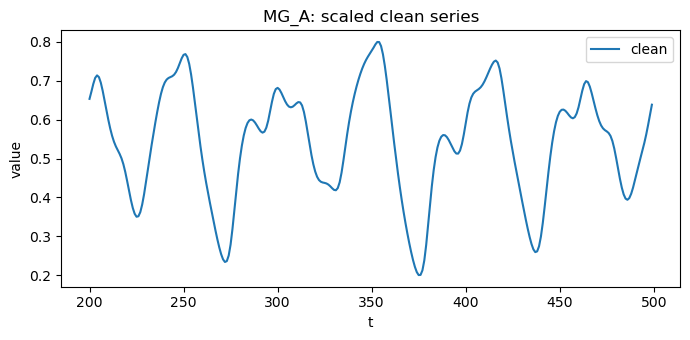

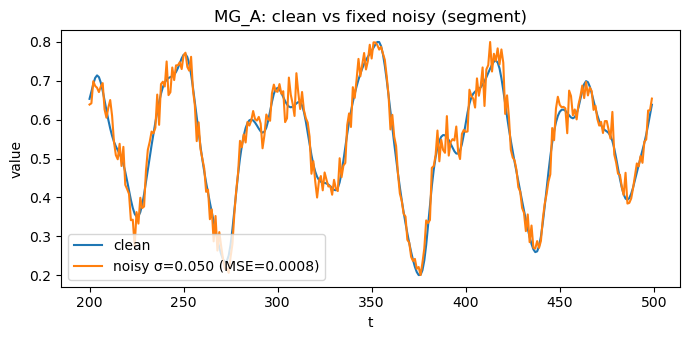

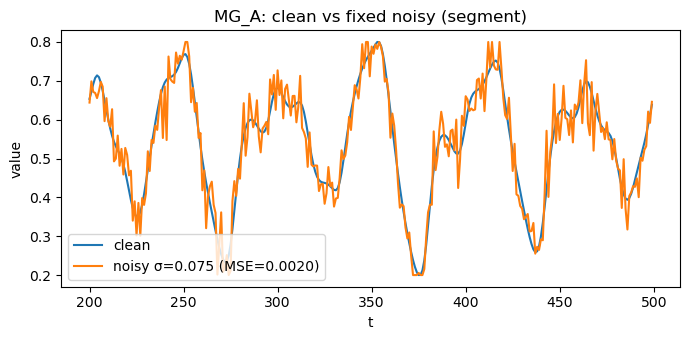

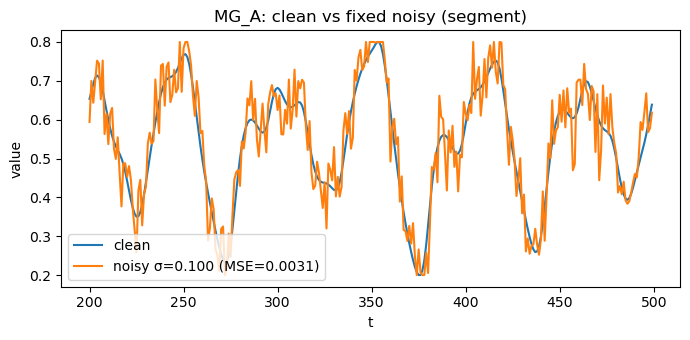

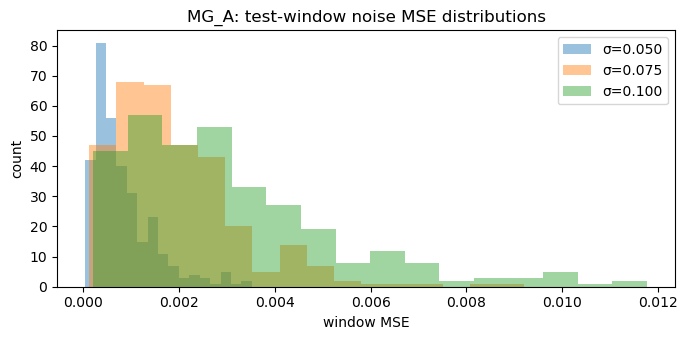

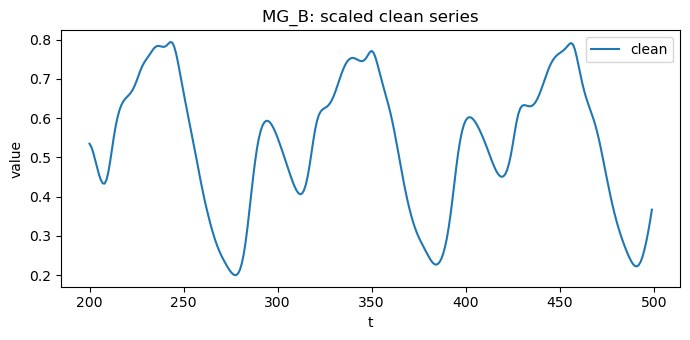

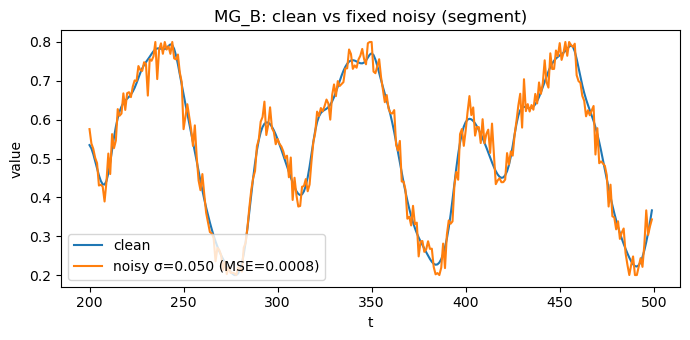

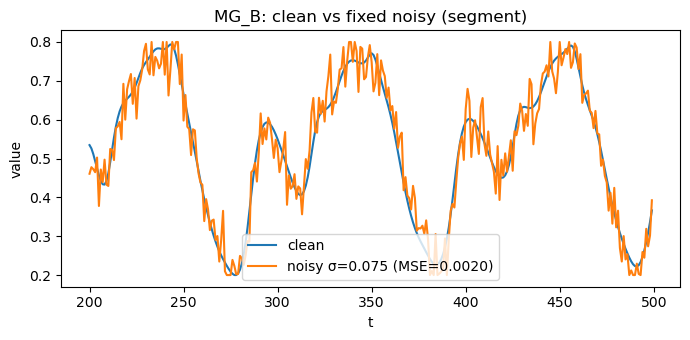

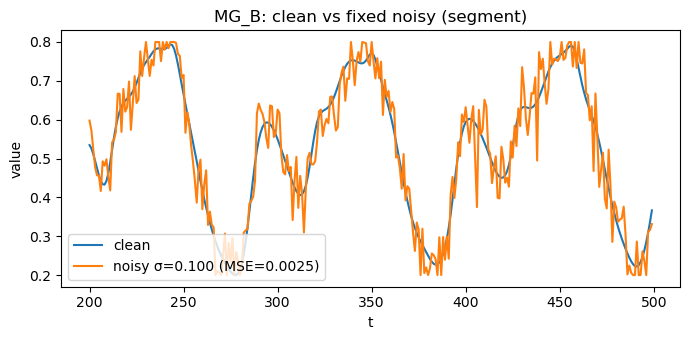

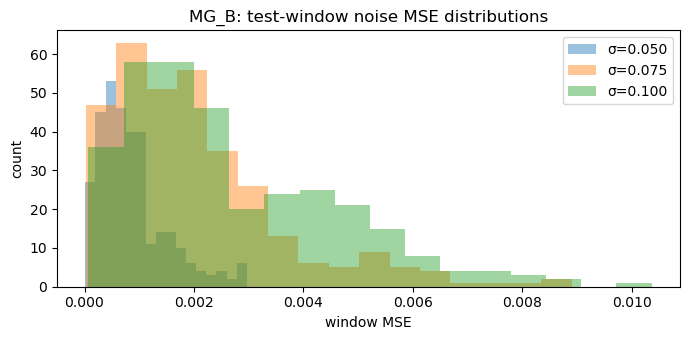

In [12]:
# === F1-VIS: dataset visualizations =========================================
import matplotlib.pyplot as plt
import numpy as np

def show_dataset_overview(datasets, sample_len=300, start=200):
    for name, ds in datasets.items():
        end = min(start + sample_len, ds.clean.shape[0])
        xs = np.arange(start, end)

        # Clean series
        plt.figure(figsize=(7,3.5))
        plt.plot(xs, ds.clean[start:end], label="clean")
        plt.title(f"{name}: scaled clean series")
        plt.xlabel("t"); plt.ylabel("value"); plt.legend(); plt.tight_layout(); plt.show()

        # Noisy overlays for each sigma
        for sigma in sorted(ds.noisy_series_by_sigma.keys()):
            noisy = ds.noisy_series_by_sigma[sigma][start:end]
            mse = float(np.mean((ds.clean[start:end] - noisy)**2))
            plt.figure(figsize=(7,3.5))
            plt.plot(xs, ds.clean[start:end], label="clean")
            plt.plot(xs, noisy, label=f"noisy σ={sigma:.3f} (MSE={mse:.4f})")
            plt.title(f"{name}: clean vs fixed noisy (segment)")
            plt.xlabel("t"); plt.ylabel("value"); plt.legend(); plt.tight_layout(); plt.show()

        # Test-split window MSE distributions per sigma
        plt.figure(figsize=(7,3.5))
        for sigma in sorted(ds.noisy_windows_by_sigma.keys()):
            # aligned windows (test partition only)
            cleanW = ds.windows_clean[ds.split_idx:]
            noisyW = ds.noisy_windows_by_sigma[sigma][ds.split_idx:]
            w_mse = np.mean((cleanW - noisyW)**2, axis=1)
            plt.hist(w_mse, bins=16, alpha=0.45, label=f"σ={sigma:.3f}")
        plt.title(f"{name}: test-window noise MSE distributions")
        plt.xlabel("window MSE"); plt.ylabel("count"); plt.legend(); plt.tight_layout(); plt.show()

show_dataset_overview(DATASETS, sample_len=300, start=200)

In [14]:
# === F2 (replace): Stage-3 Full QAE with fixed decoder (D = Eφ†) =============
import pennylane as qml
import numpy as np
from pennylane import numpy as pnp

class Stage3FixedDecoderQAE:
    """
    Inference wrapper for your full QAE:
      - Input embedding: RY(pi * v01(values))
      - Encoder: Eψ (trainable, flat vector shape = n_layers * n_qubits * 3)
      - Decoder: D = adjoint(Eφ) using theta_fixed = phi_stage1 reshaped to (L, Q, 3)
      - Readout: expval Z on all wires, mapped back to values via arccos trick.
    Exposes:
      - forward_expZ(values_window)            -> expZ on all wires after D
      - latents_after_encoder_expZ(values)     -> expZ on latent wires after Eψ (no D)
      - trash_probs_after_encoder(values)      -> probs over trash wires after Eψ (no D)
      - predict_values(values)                 -> value-domain reconstruction
    """
    def __init__(
        self,
        *,
        n_qubits: int,
        n_layers: int,
        n_latent: int = 2,
        trash_wires=None,
        scale_low: float = 0.2,
        scale_high: float = 0.8,
        psi_flat: np.ndarray,           # shape = (n_layers * n_qubits * 3,)
        theta_fixed: np.ndarray,        # shape = (n_layers, n_qubits, 3)  ← phi_stage1 reshaped
    ):
        self.n_qubits   = int(n_qubits)
        self.n_layers   = int(n_layers)
        self.n_latent   = int(n_latent)
        self.latent_wires = list(range(self.n_latent))
        self.trash_wires  = list(trash_wires) if trash_wires is not None else list(range(self.n_latent, self.n_qubits))
        self.scale_low  = float(scale_low)
        self.scale_high = float(scale_high)

        # params
        self.psi_flat    = pnp.asarray(np.asarray(psi_flat, dtype=float).ravel(), requires_grad=False)
        self.theta_fixed = pnp.asarray(np.asarray(theta_fixed, dtype=float).reshape(self.n_layers, self.n_qubits, 3),
                                       requires_grad=False)

        # device
        self.dev = qml.device("default.qubit", wires=self.n_qubits)

        # qnodes (compiled lazily)
        self._q_forward = None
        self._q_lat_stu = None
        self._q_trash   = None

    # --------- (Users: change here if your ansatz differs) ----------
    def _encoder_template(self, flat_params):
        """Eψ: RX/RY/RZ per qubit + ring CNOT, repeated L times (your Stage-1 pattern)."""
        fp = flat_params
        L, Q = self.n_layers, self.n_qubits
        for l in range(L):
            for q in range(Q):
                i = l*Q*3 + q*3
                qml.RX(fp[i+0], wires=q)
                qml.RY(fp[i+1], wires=q)
                qml.RZ(fp[i+2], wires=q)
            for q in range(Q-1):
                qml.CNOT(wires=[q, q+1])
            qml.CNOT(wires=[Q-1, 0])

    def _encoder_fixed_body(self, theta):
        """Eφ: same topology as above, using theta_fixed (L, Q, 3)."""
        T = theta
        L, Q = self.n_layers, self.n_qubits
        for l in range(L):
            for q in range(Q):
                qml.RX(T[l, q, 0], wires=q)
                qml.RY(T[l, q, 1], wires=q)
                qml.RZ(T[l, q, 2], wires=q)
            for q in range(Q-1):
                qml.CNOT(wires=[q, q+1])
            qml.CNOT(wires=[Q-1, 0])
    # ---------------------------------------------------------------

    def _decoder_fixed(self):
        """D = Eφ†."""
        qml.adjoint(self._encoder_fixed_body)(self.theta_fixed)

    # ----- embedding & readout -----
    def _embed_input_from_values(self, values_window):
        v = np.asarray(values_window, dtype=float)
        v01 = (v - self.scale_low) / max(1e-12, (self.scale_high - self.scale_low))
        thetas = np.pi * v01
        for i, th in enumerate(thetas):
            qml.RY(float(th), wires=i)

    @staticmethod
    def _readoutZ_to_values(z, low, high):
        z = np.clip(np.asarray(z, dtype=float), -0.999999, 0.999999)
        v01 = np.arccos(z) / np.pi
        return low + v01 * (high - low)

    # ----- qnode builders -----
    def _build_forward_qnode(self):
        @qml.qnode(self.dev, diff_method=None)
        def qnode(values_window):
            self._embed_input_from_values(values_window)
            self._encoder_template(self.psi_flat)
            self._decoder_fixed()
            return [qml.expval(qml.PauliZ(i)) for i in range(self.n_qubits)]
        return qnode

    def _build_latents_student_qnode(self):
        @qml.qnode(self.dev, diff_method=None)
        def qnode(values_window):
            self._embed_input_from_values(values_window)
            self._encoder_template(self.psi_flat)
            return [qml.expval(qml.PauliZ(i)) for i in self.latent_wires]
        return qnode

    def _build_trash_probs_qnode(self):
        @qml.qnode(self.dev, diff_method=None)
        def qnode(values_window):
            self._embed_input_from_values(values_window)
            self._encoder_template(self.psi_flat)
            return qml.probs(wires=self.trash_wires)
        return qnode

    # ----- public API expected by the framework -----
    def forward_expZ(self, values_window):
        if self._q_forward is None:
            self._q_forward = self._build_forward_qnode()
        return np.asarray(self._q_forward(values_window), dtype=float)

    def latents_after_encoder_expZ(self, values_window):
        if self._q_lat_stu is None:
            self._q_lat_stu = self._build_latents_student_qnode()
        return np.asarray(self._q_lat_stu(values_window), dtype=float)

    def trash_probs_after_encoder(self, values_window):
        if self._q_trash is None:
            self._q_trash = self._build_trash_probs_qnode()
        return np.asarray(self._q_trash(values_window), dtype=float)

    def map_expZ_to_values(self, z_all):
        return self._readoutZ_to_values(z_all, self.scale_low, self.scale_high)

    def predict_values(self, values_window):
        return self.map_expZ_to_values(self.forward_expZ(values_window))

In [31]:
print(5*1*2*4)

40


In [15]:
# === F3 (replace): schema-flexible parser + loader ============================
from dataclasses import dataclass
import hashlib, json, numpy as np

def _sha256_params(obj):
    buf = bytearray()
    def walk(x):
        if isinstance(x, (list, tuple)):
            for y in x: walk(y)
        elif isinstance(x, np.ndarray):
            buf.extend(np.ascontiguousarray(x, dtype=np.float64).tobytes())
        elif isinstance(x, (float, int, np.floating, np.integer)):
            buf.extend(np.asarray([x], dtype=np.float64).tobytes())
        else:
            raise TypeError(f"Unsupported param type: {type(x)}")
    walk(obj)
    return hashlib.sha256(buf).hexdigest()

@dataclass
class ModelEntry:
    name: str
    path: str
    n_qubits: int
    n_latent: int
    trash_wires: list
    scale_low: float
    scale_high: float
    noise_sigma_train: float
    meta: dict
    params: dict
    fingerprint: str
    impl: object  # must expose forward_expZ(), map_expZ_to_values(), etc.

def parse_model_json(path):
    with open(path, "r", encoding="utf-8") as f:
        J = json.load(f)

    # -----------------------------
    # Path A) Your model_bundle.json schema
    # -----------------------------
    if "parameters" in J and ("psi_stage3" in J["parameters"] or "phi_stage1" in J["parameters"]):
        P = J["parameters"]
        psi_flat    = np.asarray(P["psi_stage3"], dtype=float).ravel()
        phi_stage1  = np.asarray(P["phi_stage1"], dtype=float).ravel()

        arch = J.get("architecture", {})
        ds   = J.get("dataset", {})
        run  = J.get("run", {})

        n_qubits = int(arch.get("n_qubits", ds.get("window_size", 4)))
        n_latent = int(arch.get("n_latent", 2))
        trash_wires = list(arch.get("trash_wires", range(n_latent, n_qubits)))
        scale_low  = float(ds.get("scale_low", 0.2))
        scale_high = float(ds.get("scale_high", 0.8))
        n_layers_info = arch.get("n_layers", None)

        if psi_flat.size % (n_qubits * 3) != 0:
            raise ValueError(f"psi_stage3 length {psi_flat.size} not divisible by n_qubits*3={n_qubits*3}")
        n_layers_infer = psi_flat.size // (n_qubits * 3)
        n_layers = int(n_layers_info) if n_layers_info is not None else int(n_layers_infer)
        if n_layers != n_layers_infer:
            print(f"[loader] Adjusting n_layers from {n_layers} → {n_layers_infer} (inferred from psi_stage3).")
            n_layers = n_layers_infer

        theta_fixed = phi_stage1.reshape(n_layers, n_qubits, 3)

        info = {
            "n_qubits": n_qubits,
            "n_latent": n_latent,
            "trash_wires": trash_wires,
            "scale_low": scale_low,
            "scale_high": scale_high,
            "n_layers": n_layers,
            "noise_sigma_train": float(run.get("sigma_train", np.nan)),
            "timestamp": J.get("timestamp"),
            "source_schema": "qae_model_bundle:1.0",
            **arch,
        }
        return {
            "psi_flat": psi_flat,
            "theta_fixed": theta_fixed,
            "info": info
        }

    # -----------------------------
    # Path B) Fallback to earlier schema (encoder/decoder_params)
    # -----------------------------
    mp = J.get("model_parameters") or J.get("params") or {}
    enc = mp.get("encoder_params") or J.get("encoder_params")
    dec = mp.get("decoder_params") or J.get("decoder_params")
    if enc is None or dec is None:
      raise ValueError("Unsupported JSON schema for this notebook.")
    info0 = J.get("model_info") or J.get("meta") or J.get("config") or {}
    return {
        "psi_flat": np.asarray(enc, dtype=float).ravel(),
        "theta_fixed": np.asarray(dec, dtype=float).reshape(info0.get("n_layers", 3), info0.get("n_qubits", 4), 3),
        "info": {
            "n_qubits": int(info0.get("n_qubits_total", info0.get("n_qubits", 4))),
            "n_latent": int(info0.get("n_latent", 2)),
            "trash_wires": info0.get("trash_wires", list(range(int(info0.get("n_latent", 2)), int(info0.get("n_qubits", 4))))),
            "scale_low": float(info0.get("scale_low", 0.2)),
            "scale_high": float(info0.get("scale_high", 0.8)),
            "n_layers": int(info0.get("n_layers", 3)),
            "noise_sigma_train": float(info0.get("noise_sigma_train", np.nan)),
            **info0,
        }
    }

def instantiate_model(parsed):
    info = parsed["info"]
    impl = Stage3FixedDecoderQAE(
        n_qubits=info["n_qubits"],
        n_layers=info["n_layers"],
        n_latent=info["n_latent"],
        trash_wires=info["trash_wires"],
        scale_low=info["scale_low"],
        scale_high=info["scale_high"],
        psi_flat=parsed["psi_flat"],
        theta_fixed=parsed["theta_fixed"],
    )
    return impl

def load_models(model_paths):
    registry = {}
    for name, path in model_paths.items():
        try:
            parsed = parse_model_json(path)
            impl = instantiate_model(parsed)
            fp = _sha256_params([parsed["psi_flat"], parsed["theta_fixed"]])
            info = parsed["info"]
            entry = ModelEntry(
                name=name,
                path=path,
                n_qubits=info["n_qubits"],
                n_latent=info["n_latent"],
                trash_wires=list(info["trash_wires"]),
                scale_low=info["scale_low"],
                scale_high=info["scale_high"],
                noise_sigma_train=float(info["noise_sigma_train"]),
                meta=info,
                params={"psi_flat": parsed["psi_flat"], "theta_fixed": parsed["theta_fixed"]},
                fingerprint=fp,
                impl=impl
            )
            registry[name] = entry
            print(f"✓ Loaded {name} (nq={entry.n_qubits}, L={info['n_layers']}, σ_train={entry.noise_sigma_train:g})")
        except Exception as e:
            print(f"✗ {name}: {e}")
    return registry

print("Stage-3 loader ready. Point MODEL_PATHS to your model_bundle.json")

Stage-3 loader ready. Point MODEL_PATHS to your model_bundle.json


In [13]:
# === F4: evaluation on standardized datasets (fixed noisy inputs) ===========

from dataclasses import dataclass
import numpy as np

@dataclass
class EvalResult:
    noisy_mse: np.ndarray
    model_mse: np.ndarray
    delta_pct: np.ndarray
    delta_pct_sym: np.ndarray
    recon_values: np.ndarray
    noisy_values: np.ndarray
    clean_values: np.ndarray
    lat_clean: np.ndarray|None
    lat_noisy: np.ndarray|None
    p00_trash: np.ndarray|None

def _sigma_key(s):
    return float(np.round(float(s), 3))

def eval_model_on_dataset(entry, ds, n_eval=20, sigma=None):
    """
    Evaluate a model on a dataset using the dataset's *fixed* noisy windows.
    - If sigma is None, uses entry.noise_sigma_train (rounded to 3 decimals).
    - Always evaluates the *same* aligned test windows for every model.
    """
    low, high = entry.scale_low, entry.scale_high
    s = entry.noise_sigma_train if sigma is None else float(sigma)
    s_key = _sigma_key(s)

    if s_key not in ds.noisy_windows_by_sigma:
        available = ", ".join([f"{k:.3f}" for k in sorted(ds.noisy_windows_by_sigma.keys())])
        raise ValueError(f"{ds.name}: requested σ={s_key:.3f} not in fixed variants [{available}]. "
                         f"Adjust NOISE_GRID or the model's noise_sigma_train.")

    # Aligned clean/noisy windows from the standardized *test* split
    cleanW = ds.windows_clean[ds.split_idx:]
    noisyW = ds.noisy_windows_by_sigma[s_key][ds.split_idx:]
    N = min(int(n_eval), len(cleanW))
    cleanW = cleanW[:N]
    noisyW = noisyW[:N]

    recon = []
    nmse, dmse = [], []
    d_pct, d_pct_sym = [], []
    lat_c, lat_n, p00s = [], [], []

    impl = entry.impl

    for w_clean, w_noisy in zip(cleanW, noisyW):
        z_pred = impl.forward_expZ(w_noisy)
        y_pred = impl.map_expZ_to_values(z_pred)  # values domain
        recon.append(y_pred)

        mse_n = float(np.mean((w_clean - w_noisy)**2))
        mse_d = float(np.mean((w_clean - y_pred)**2))
        nmse.append(mse_n); dmse.append(mse_d)

        # classic Δ%
        d_pct.append(0.0 if mse_n < 1e-12 else 100.0 * (mse_n - mse_d) / mse_n)
        # symmetric Δ% (bounded, more stable)
        denom = max(mse_n + mse_d, 1e-12)
        d_pct_sym.append(200.0 * (mse_n - mse_d) / denom)

        # Optional hooks
        try:
            lat_clean = impl.latents_after_encoder_expZ(w_clean)
            lat_noisy = impl.latents_after_encoder_expZ(w_noisy)
            lat_c.append(lat_clean); lat_n.append(lat_noisy)
        except Exception:
            lat_c = lat_n = None

        try:
            P = impl.trash_probs_after_encoder(w_noisy)  # probs over trash wires
            p00s.append(float(P[0]))
        except Exception:
            p00s = None

    recon = np.asarray(recon)
    nmse  = np.asarray(nmse);  dmse = np.asarray(dmse)
    d_pct = np.asarray(d_pct); d_pct_sym = np.asarray(d_pct_sym)

    lat_c = None if lat_c is None else np.asarray(lat_c)
    lat_n = None if lat_n is None else np.asarray(lat_n)
    p00s  = None if p00s is None else np.asarray(p00s)

    return EvalResult(
        noisy_mse=nmse, model_mse=dmse, delta_pct=d_pct, delta_pct_sym=d_pct_sym,
        recon_values=recon, noisy_values=noisyW, clean_values=cleanW,
        lat_clean=lat_c, lat_noisy=lat_n, p00_trash=p00s
    )

def summarize_eval(er):
    mean_imp, lo_imp, hi_imp = bootstrap_ci_mean(er.delta_pct)
    mean_sym, lo_sym, hi_sym = bootstrap_ci_mean(er.delta_pct_sym)
    p_val = sign_test_pvalue(er.noisy_mse - er.model_mse)
    succ  = 100.0 * float(np.mean(er.delta_pct > 0))
    return {
        "noisy_MSE_mean": float(np.mean(er.noisy_mse)),
        "model_MSE_mean": float(np.mean(er.model_mse)),
        "delta_pct_mean": float(mean_imp),
        "delta_pct_CI95": [float(lo_imp), float(hi_imp)],
        "delta_pct_sym_mean": float(mean_sym),
        "delta_pct_sym_CI95": [float(lo_sym), float(hi_sym)],
        "sign_test_p": float(p_val),
        "success_rate_pct": float(succ),
        "n_windows": int(er.noisy_mse.size)
    }

In [6]:
# === F5: plotting helpers ====================================================

def plot_reconstruction_example(er: EvalResult, idx=0, title="Reconstruction"):
    c = er.clean_values[idx]; n = er.noisy_values[idx]; d = er.recon_values[idx]
    xs = np.arange(len(c))
    plt.figure()
    plt.plot(xs, c, label="clean")
    plt.plot(xs, n, label="noisy")
    plt.plot(xs, d, label="denoised")
    plt.title(title); plt.xlabel("t"); plt.ylabel("value"); plt.legend(); plt.show()

def plot_delta_distributions(er_by_model, title="ΔMSE% (per-window)"):
    plt.figure()
    for name, er in er_by_model.items():
        plt.hist(er.delta_pct, bins=12, alpha=0.5, label=name)
    plt.title(title); plt.xlabel("improvement %"); plt.ylabel("count"); plt.legend(); plt.show()

def plot_robustness(entry, ds: Dataset, sigmas=(0.05, 0.075, 0.10), n_eval=20):
    means, lows, highs = [], [], []
    for s in sigmas:
        er = eval_model_on_dataset(entry, ds, n_eval=n_eval, sigma=s)
        m, lo, hi = bootstrap_ci_mean(er.delta_pct)
        means.append(m); lows.append(lo); highs.append(hi)
    plt.figure()
    plt.plot(sigmas, means, marker="o")
    plt.fill_between(sigmas, lows, highs, alpha=0.2)
    plt.xlabel("σ"); plt.ylabel("ΔMSE% (mean, 95%CI)")
    plt.title(f"Robustness on {ds.name} — {entry.name}"); plt.show()

def plot_latent_trash(er: EvalResult, entry: ModelEntry, dsname):
    if er.lat_clean is not None and er.lat_noisy is not None:
        diffs = np.mean((er.lat_clean - er.lat_noisy)**2, axis=1)
        plt.figure()
        plt.hist(diffs, bins=12)
        plt.title(f"Latent drift MSE (clean vs noisy) — {entry.name} on {dsname}")
        plt.xlabel("MSE"); plt.ylabel("count"); plt.show()
    if er.p00_trash is not None:
        plt.figure()
        plt.hist(er.p00_trash, bins=12)
        plt.title(f"Trash P(|00⟩) after encoder — {entry.name} on {dsname}")
        plt.xlabel("P00"); plt.ylabel("count"); plt.show()

In [7]:
# === F6: run benchmark across all loaded models ==============================

def run_benchmark(model_registry, datasets=DATASETS, n_eval=20):
    all_results = {}
    all_summaries = {}
    for dsname, ds in datasets.items():
        all_results[dsname] = {}
        all_summaries[dsname] = {}
        for name, entry in model_registry.items():
            er = eval_model_on_dataset(entry, ds, n_eval=n_eval, sigma=None)
            sm = summarize_eval(er)
            all_results[dsname][name] = er
            all_summaries[dsname][name] = sm
            print(f"{dsname} | {name:20s}  Δ%={sm['delta_pct_mean']:+5.1f} "
                  f"(CI {sm['delta_pct_CI95'][0]:+.1f},{sm['delta_pct_CI95'][1]:+.1f})  "
                  f"p={sm['sign_test_p']:.4f}")
    return all_results, all_summaries

def bar_compare_summaries(summaries_for_ds, title):
    names = list(summaries_for_ds.keys())
    vals  = [summaries_for_ds[n]["delta_pct_mean"] for n in names]
    cis   = [summaries_for_ds[n]["delta_pct_CI95"] for n in names]
    lo = [v - c[0] for v,c in zip(vals, cis)]
    hi = [c[1] - v for v,c in zip(vals, cis)]
    plt.figure()
    xs = np.arange(len(names))
    plt.bar(xs, vals, yerr=[lo, hi], capsize=4)
    plt.xticks(xs, names, rotation=30, ha="right")
    plt.ylabel("ΔMSE% mean (95%CI)")
    plt.title(title)
    plt.tight_layout(); plt.show()

✓ Loaded Me_run_20250824_nq4_s010 (nq=4, L=3, σ_train=0.1)
MG_A | Me_run_20250824_nq4_s010  Δ%=+17.4 (CI +9.5,+25.4)  p=0.0414
MG_B | Me_run_20250824_nq4_s010  Δ%=+12.9 (CI +5.1,+20.3)  p=0.0118


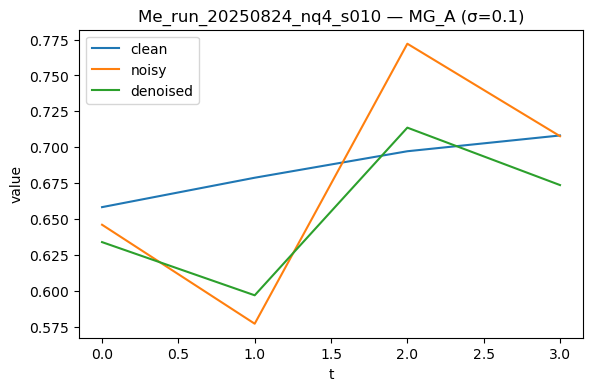

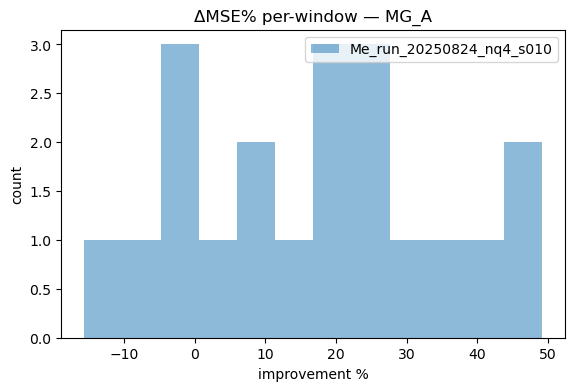

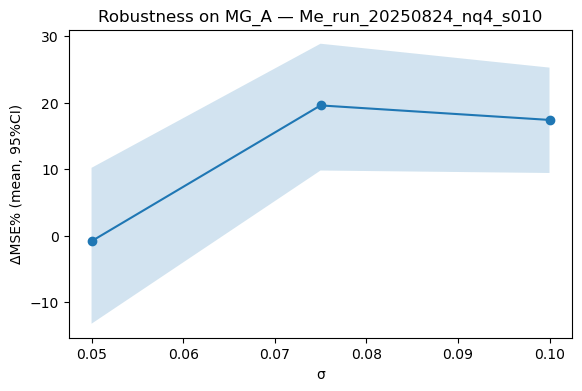

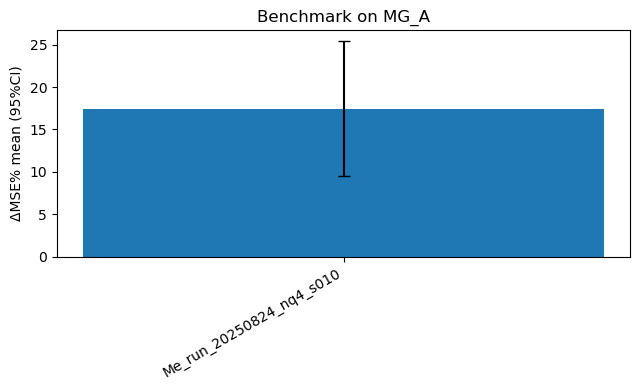

In [18]:
# === F7 (use): load your saved bundle and run the standardized benchmark =====

MODEL_PATHS = {
    # ↓↓↓ your real bundle ↓↓↓
    "Me_run_20250824_nq4_s010": "/Users/jacobzwoniarski/Desktop/qae_architectures/Jacob/runs_qae/unknown_dataset/run_20250824-171313/model_bundle.json"
    # To add more, append: "Tag": "/path/to/another/model_bundle.json"
}

REG = load_models(MODEL_PATHS)

# (Optional) sanity: dataset window size vs n_qubits
for name, entry in REG.items():
    if entry.n_qubits != WINDOW_SIZE:
        warnings.warn(f"{name}: n_qubits={entry.n_qubits} but DATASETS WINDOW_SIZE={WINDOW_SIZE}.")

# Run benchmark on both standardized datasets (MG_A, MG_B)
ALL_RESULTS, ALL_SUMMARIES = run_benchmark(REG, datasets=DATASETS, n_eval=20)

# Quick visuals for the first dataset and model
if REG:
    dsname = list(DATASETS.keys())[0]
    name0, entry0 = next(iter(REG.items()))
    er0 = ALL_RESULTS[dsname][name0]

    plot_reconstruction_example(er0, idx=0, title=f"{name0} — {dsname} (σ={entry0.noise_sigma_train:g})")
    plot_delta_distributions({name: ALL_RESULTS[dsname][name] for name in list(REG)[:min(3,len(REG))]},
                             title=f"ΔMSE% per-window — {dsname}")
    plot_robustness(entry0, DATASETS[dsname], sigmas=(0.05, 0.075, 0.10), n_eval=20)
    bar_compare_summaries(ALL_SUMMARIES[dsname], title=f"Benchmark on {dsname}")

In [9]:
# === F8: compare curated "median" models across noise levels =================

def panel_noise_curves(model_registry, datasets=DATASETS, model_names=None, sigmas=(0.05,0.075,0.10), n_eval=20):
    if model_names is None: model_names = list(model_registry.keys())
    for dsname, ds in datasets.items():
        plt.figure()
        for name in model_names:
            if name not in model_registry: 
                warnings.warn(f"{name} not loaded"); continue
            entry = model_registry[name]
            means = []
            for s in sigmas:
                er = eval_model_on_dataset(entry, ds, n_eval=n_eval, sigma=s)
                m,_,_ = bootstrap_ci_mean(er.delta_pct)
                means.append(m)
            plt.plot(sigmas, means, marker="o", label=name)
        plt.xlabel("σ"); plt.ylabel("ΔMSE% mean"); plt.title(f"Curated panel — {dsname}")
        plt.legend(); plt.show()

# Example:
# MEDIANS = ["TeamA_nq4_noise050_med", "TeamA_nq6_noise075_med", "TeamA_nq8_noise100_med",
#            "TeamB_nq4_noise050_med", "TeamB_nq6_noise075_med", "TeamB_nq8_noise100_med"]
# panel_noise_curves(REG, DATASETS, model_names=MEDIANS, sigmas=(0.05,0.075,0.10), n_eval=20)

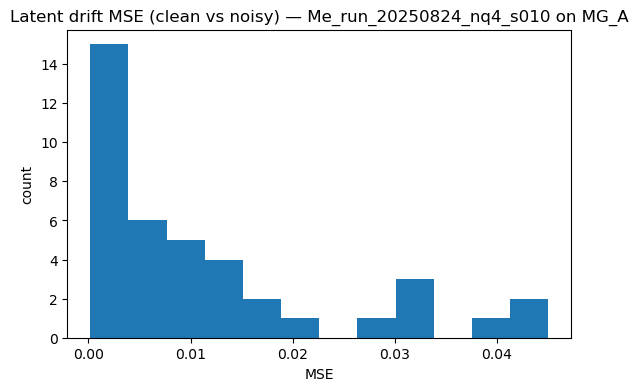

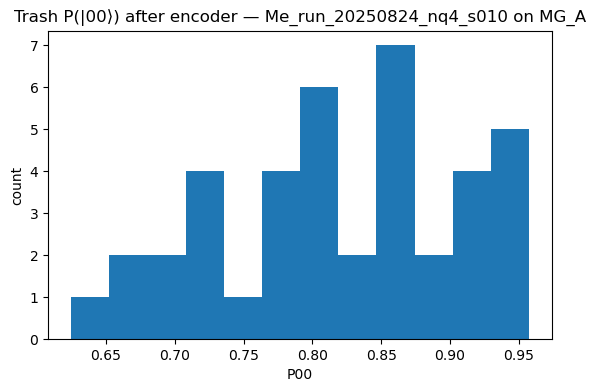

MG_A | Me_run_20250824_nq4_s010 | Corr(P00, MSE) = +0.008


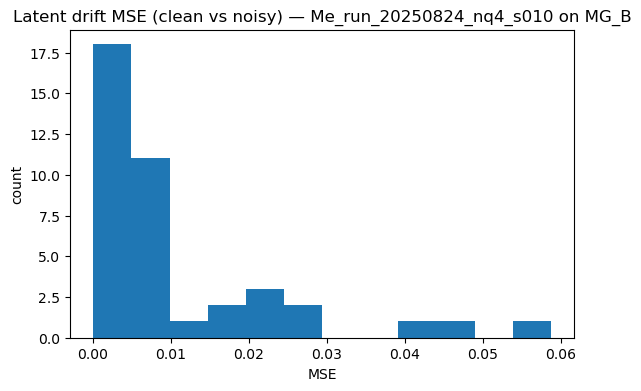

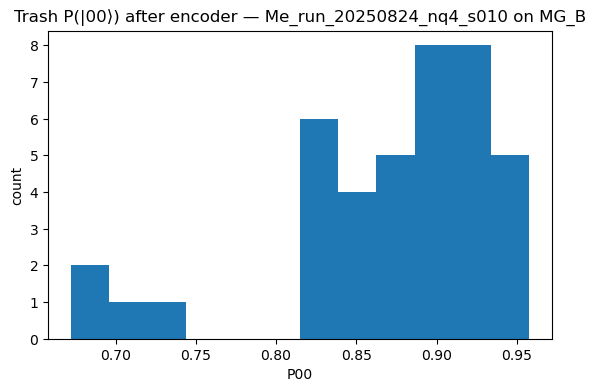

MG_B | Me_run_20250824_nq4_s010 | Corr(P00, MSE) = -0.397


In [19]:
# === F9: optional latent/trash diagnostics ===================================

def latent_trash_report(entry, ds: Dataset, n_eval=40):
    er = eval_model_on_dataset(entry, ds, n_eval=n_eval, sigma=None)
    plot_latent_trash(er, entry, ds.name)
    if er.p00_trash is not None:
        # correlation between P00 and reconstruction error
        errs = np.mean((er.clean_values - er.recon_values)**2, axis=1)
        corr = float(np.corrcoef(er.p00_trash, errs)[0,1])
        print(f"{ds.name} | {entry.name} | Corr(P00, MSE) = {corr:+.3f}")

# Example (first model only):
if REG:
    entry = next(iter(REG.values()))
    for ds in DATASETS.values():
        latent_trash_report(entry, ds, n_eval=40)

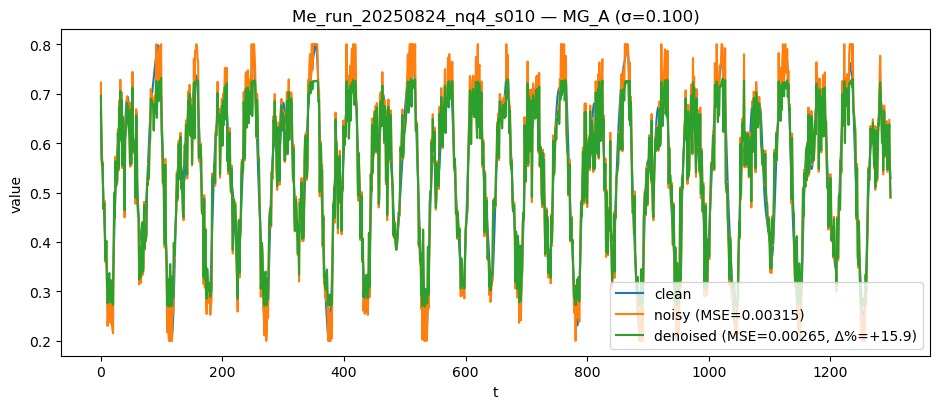

MG_A: full-series ΔMSE% = +15.9


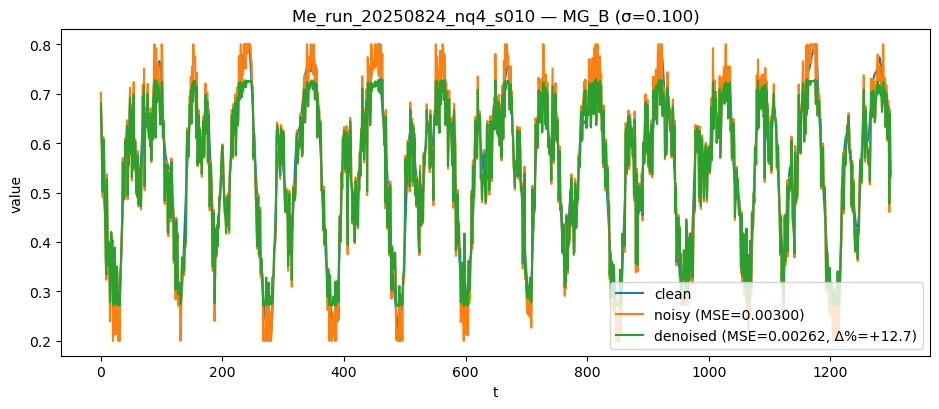

MG_B: full-series ΔMSE% = +12.7


In [22]:
# === F10: Full-series reconstruction (no split) ==============================
import numpy as np
import matplotlib.pyplot as plt

def _flatten_avg(windows, step):
    """Average-overlap flattening of (N, W) windows into a single 1D series."""
    windows = np.asarray(windows, dtype=float)
    N, W = windows.shape
    L = (N - 1) * step + W
    acc = np.zeros(L, float)
    cnt = np.zeros(L, float)
    for i in range(N):
        s = i * step
        e = s + W
        acc[s:e] += windows[i]
        cnt[s:e] += 1.0
    return acc / np.maximum(cnt, 1e-12)

def reconstruct_full_series(entry, ds, sigma=None, step=None):
    """
    Build clean vs fixed noisy vs denoised full-length series for one dataset.
    Uses the dataset's fixed noisy *windows* so results are deterministic.
    """
    # pick sigma
    s = entry.noise_sigma_train if sigma is None else float(sigma)
    s_key = float(np.round(s, 3))
    if s_key not in ds.noisy_windows_by_sigma:
        available = ", ".join([f"{k:.3f}" for k in sorted(ds.noisy_windows_by_sigma)])
        raise ValueError(f"{ds.name}: σ={s_key:.3f} not available. Options: [{available}]")

    # get windows across the entire series
    cleanW = np.asarray(ds.windows_clean, dtype=float)                # (N, W)
    noisyW = np.asarray(ds.noisy_windows_by_sigma[s_key], dtype=float)
    assert cleanW.shape == noisyW.shape, "clean/noisy window shapes must match"

    # model predictions per window
    impl = entry.impl
    preds = []
    for w_noisy in noisyW:
        z = impl.forward_expZ(w_noisy)
        y = impl.map_expZ_to_values(z)   # decode values from expZ
        preds.append(y)
    preds = np.asarray(preds, dtype=float)  # (N, W)

    # flatten by averaging overlaps
    if step is None:
        step = globals().get("WINDOW_STEP", 1)
    flat_clean = _flatten_avg(cleanW, step)
    flat_noisy = _flatten_avg(noisyW, step)
    flat_deno  = _flatten_avg(preds,  step)

    # metrics
    mse_noisy = float(np.mean((flat_clean - flat_noisy)**2))
    mse_deno  = float(np.mean((flat_clean - flat_deno )**2))
    delta_pct = 0.0 if mse_noisy < 1e-12 else 100.0 * (mse_noisy - mse_deno) / mse_noisy

    return {
        "clean": flat_clean, "noisy": flat_noisy, "deno": flat_deno,
        "mse_noisy": mse_noisy, "mse_deno": mse_deno, "delta_pct": delta_pct,
        "sigma": s_key, "step": step
    }

def plot_full_series(rec, title=None):
    L = len(rec["clean"])
    xs = np.arange(L)
    plt.figure(figsize=(9.5, 4.2))
    plt.plot(xs, rec["clean"], label="clean")
    plt.plot(xs, rec["noisy"], label=f"noisy (MSE={rec['mse_noisy']:.5f})")
    plt.plot(xs, rec["deno"],  label=f"denoised (MSE={rec['mse_deno']:.5f}, Δ%={rec['delta_pct']:+.1f})")
    plt.xlabel("t"); plt.ylabel("value")
    if title is None:
        title = f"Full-series reconstruction (σ={rec['sigma']:.3f})"
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

# --- Example usage -----------------------------------------------------------
# Users: change "Me_run_20250824_nq4_s010" to your model key if different.
if REG:
    entry = next(iter(REG.values()))  # first loaded model
    for dsname, ds in DATASETS.items():
        rec = reconstruct_full_series(entry, ds, sigma=entry.noise_sigma_train)
        plot_full_series(rec, title=f"{entry.name} — {dsname} (σ={rec['sigma']:.3f})")
        print(f"{dsname}: full-series ΔMSE% = {rec['delta_pct']:+.1f}")

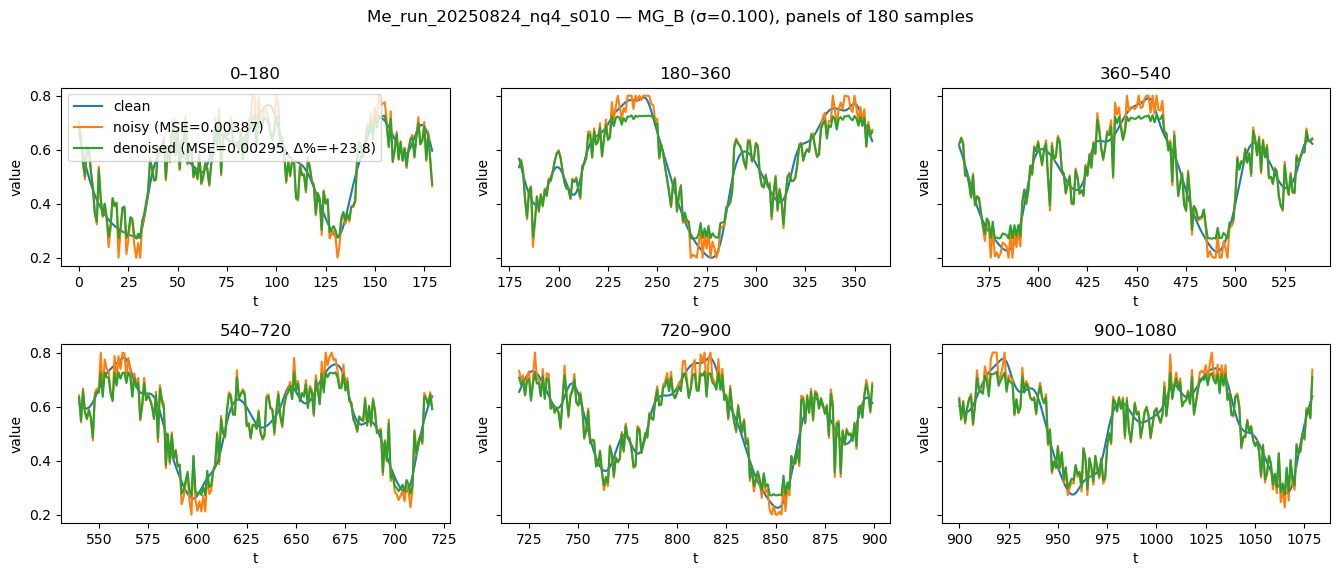

In [23]:
# === F10b: Panelized full-series views (clean vs noisy vs denoised) =========
import numpy as np
import matplotlib.pyplot as plt

def plot_full_series_panels(entry, ds, sigma=None,
                            panel_len=200, ncols=3, nrows=2, start=0,
                            sharey=True, show_errors=False):
    """
    Split the full deterministic series into smaller panels so differences pop.
    - entry: ModelEntry from REG
    - ds:    one of DATASETS['MG_A'] / ['MG_B']
    - sigma: None -> use entry.noise_sigma_train
    - panel_len:   samples per panel (try 120–300)
    - ncols/nrows: grid layout (each panel is its own zoom)
    - start:       first sample to show
    - sharey:      keep a common y-axis across panels (makes gaps easier to see)
    - show_errors: if True, also plot absolute error |clean - (…)|
    """
    rec = reconstruct_full_series(entry, ds, sigma=sigma)
    c, n, d = rec["clean"], rec["noisy"], rec["deno"]
    L = len(c)

    total_panels = ncols * nrows
    fig, axes = plt.subplots(nrows, ncols, figsize=(4.5*ncols, 2.8*nrows),
                             sharex=False, sharey=sharey)
    axes = np.atleast_1d(axes).ravel()

    for k in range(total_panels):
        s = start + k * panel_len
        e = min(s + panel_len, L)
        ax = axes[k]

        if s >= L:
            ax.axis("off")
            continue

        xs = np.arange(s, e)
        cc = c[s:e]; nn = n[s:e]; dd = d[s:e]

        # local metrics for this zoom
        mse_n = float(np.mean((cc - nn)**2))
        mse_d = float(np.mean((cc - dd)**2))
        d_pct = 0.0 if mse_n < 1e-12 else 100.0 * (mse_n - mse_d) / mse_n

        ax.plot(xs, cc, label="clean")
        ax.plot(xs, nn, label=f"noisy (MSE={mse_n:.5f})")
        ax.plot(xs, dd, label=f"denoised (MSE={mse_d:.5f}, Δ%={d_pct:+.1f})")

        if show_errors:
            ax2 = ax.twinx()
            ax2.plot(xs, np.abs(cc - nn), alpha=0.35)
            ax2.plot(xs, np.abs(cc - dd), alpha=0.35)
            ax2.set_ylabel("abs error")

        ax.set_xlabel("t"); ax.set_ylabel("value")
        ax.set_title(f"{s}–{e}")

        # only first panel gets the legend to avoid clutter
        if k == 0:
            ax.legend(loc="upper left")

    fig.suptitle(f"{entry.name} — {ds.name} (σ={rec['sigma']:.3f}), panels of {panel_len} samples",
                 y=1.02, fontsize=12)
    plt.tight_layout()
    plt.show()

# --- Example: same model, panelized on MG_B (adjust panel_len/start as you like)
if REG:
    entry = next(iter(REG.values()))
    plot_full_series_panels(entry, DATASETS["MG_B"], sigma=None,
                            panel_len=180, ncols=3, nrows=2, start=0, sharey=True)
    # you can move the window along the series by changing `start`, e.g.:
    # plot_full_series_panels(entry, DATASETS["MG_B"], panel_len=180, ncols=3, nrows=2, start=540)

MG_B | Me_run_20250824_nq4_s010 | σ=0.100
Global MSE: noisy=0.00300  deno=0.00262  Δ%=+12.7
Samples improved: 64.0%   median per-sample ΔMSE=+0.000151


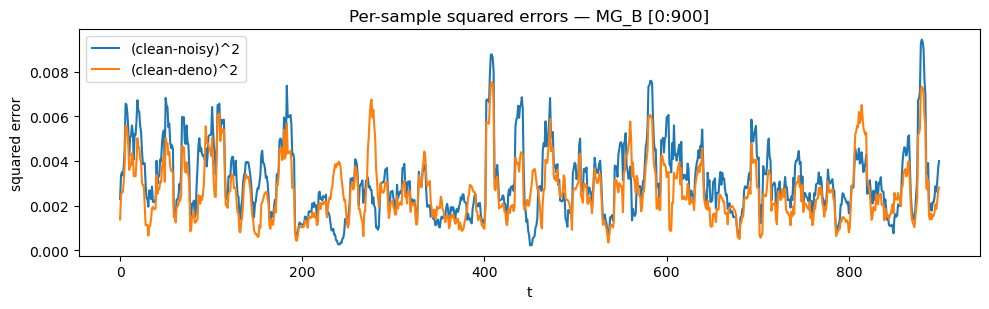

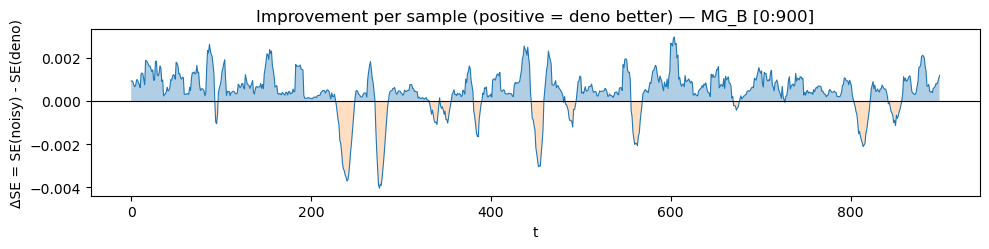

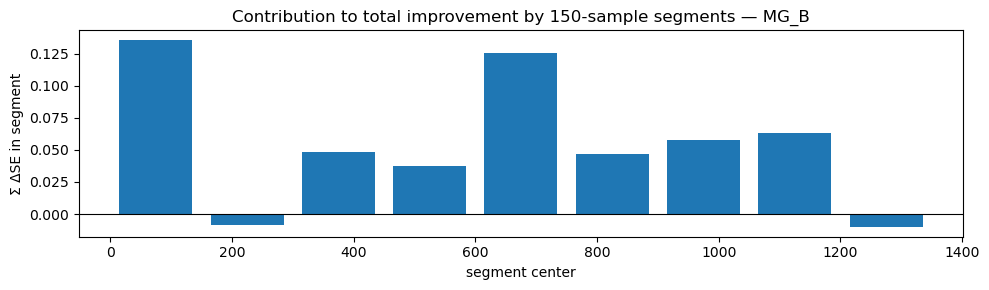

Corr(|Δ clean|, improvement) = +0.133  (positive → more gain on fast changes)
MG_B | Me_run_20250824_nq4_s010 | σ=0.100
Global MSE: noisy=0.00300  deno=0.00262  Δ%=+12.7
Samples improved: 64.0%   median per-sample ΔMSE=+0.000151


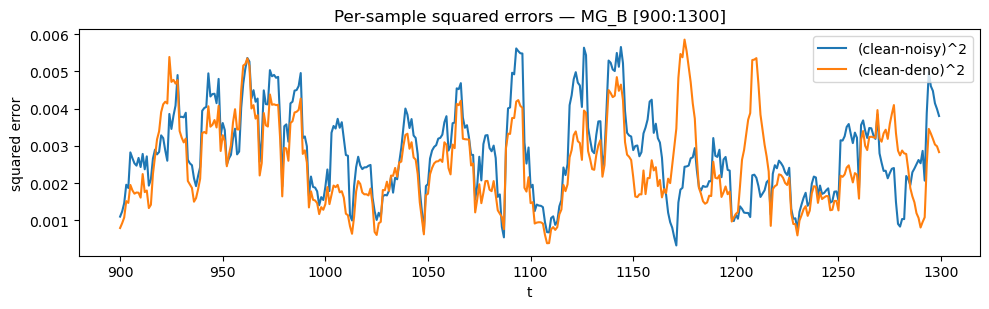

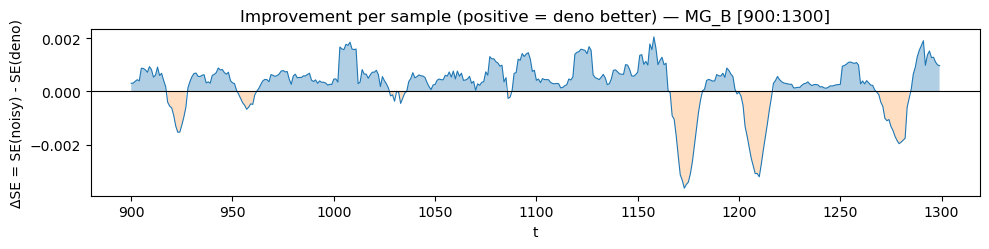

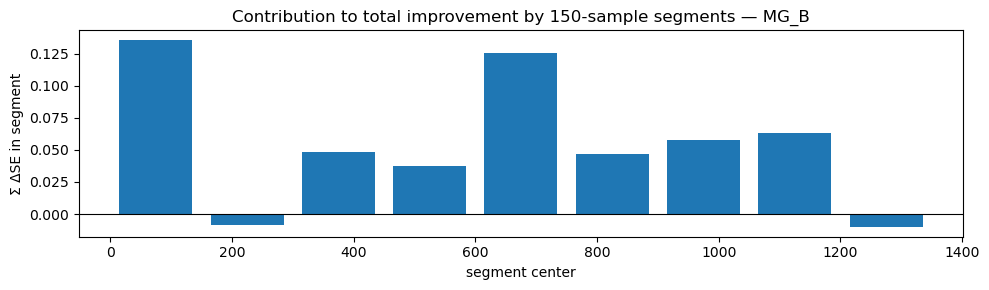

Corr(|Δ clean|, improvement) = +0.133  (positive → more gain on fast changes)
MG_A | Me_run_20250824_nq4_s010 | σ=0.100
Global MSE: noisy=0.00315  deno=0.00265  Δ%=+15.9
Samples improved: 66.3%   median per-sample ΔMSE=+0.000143


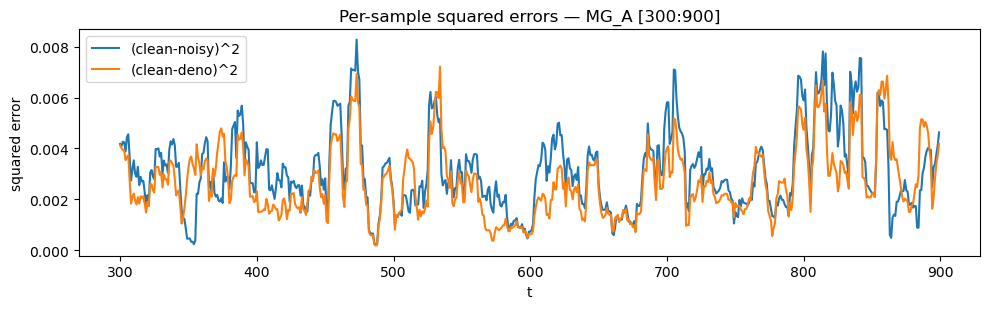

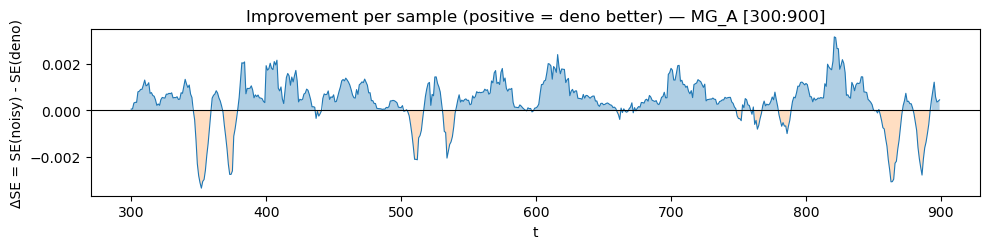

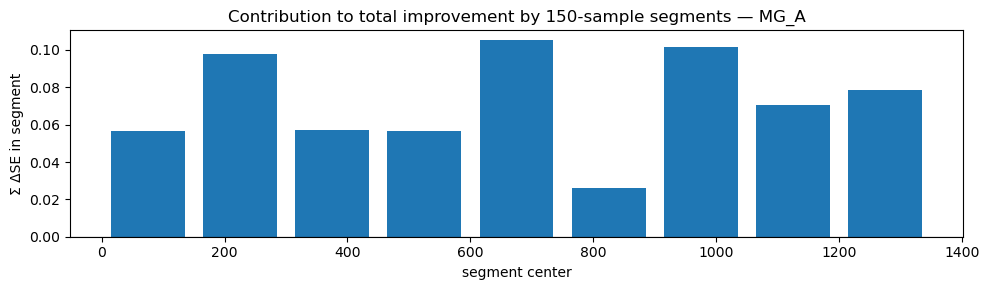

Corr(|Δ clean|, improvement) = +0.091  (positive → more gain on fast changes)


In [25]:
# === F10c: "Error lens" — show where the gains happen =======================
import numpy as np
import matplotlib.pyplot as plt

def error_lens(entry, ds, sigma=None, seg=150, smooth=7, start=0, length=None):
    """
    Visualize per-sample error reduction:
      - error traces: (clean-noisy)^2 vs (clean-deno)^2
      - improvement shading: green where deno < noisy, red otherwise
      - segment contributions: which chunks of the series contribute most
    """
    rec = reconstruct_full_series(entry, ds, sigma=sigma)
    c, n, d = rec["clean"], rec["noisy"], rec["deno"]
    L = len(c)
    if length is None: length = L - start
    s, e = int(start), int(min(start + length, L))

    se_n = (n - c)**2
    se_d = (d - c)**2
    imp  = se_n - se_d          # >0 = improvement

    mean_n = float(se_n.mean()); mean_d = float(se_d.mean())
    d_pct  = 100.0 * (mean_n - mean_d) / max(mean_n, 1e-12)
    frac_help = 100.0 * float(np.mean(imp > 0))
    print(f"{ds.name} | {entry.name} | σ={rec['sigma']:.3f}")
    print(f"Global MSE: noisy={mean_n:.5f}  deno={mean_d:.5f}  Δ%={d_pct:+.1f}")
    print(f"Samples improved: {frac_help:.1f}%   median per-sample ΔMSE={np.median(imp):+.6f}")

    xs = np.arange(s, e)
    # optional smoothing for plotting only
    if smooth and smooth > 1:
        from scipy.ndimage import uniform_filter1d
        se_n_plot = uniform_filter1d(se_n[s:e], size=smooth, mode="nearest")
        se_d_plot = uniform_filter1d(se_d[s:e], size=smooth, mode="nearest")
        imp_plot  = se_n_plot - se_d_plot
    else:
        se_n_plot = se_n[s:e]; se_d_plot = se_d[s:e]; imp_plot = imp[s:e]

    # 1) Error traces
    plt.figure(figsize=(10,3.2))
    plt.plot(xs, se_n_plot, label="(clean-noisy)^2")
    plt.plot(xs, se_d_plot, label="(clean-deno)^2")
    plt.title(f"Per-sample squared errors — {ds.name} [{s}:{e}]")
    plt.xlabel("t"); plt.ylabel("squared error")
    plt.legend(); plt.tight_layout(); plt.show()

    # 2) Improvement shading
    plt.figure(figsize=(10,2.6))
    plt.plot(xs, imp_plot, linewidth=0.8)
    plt.fill_between(xs, 0, imp_plot, where=(imp_plot>=0), alpha=0.35, step=None)
    plt.fill_between(xs, 0, imp_plot, where=(imp_plot< 0),  alpha=0.25, step=None)
    plt.axhline(0, color="k", linewidth=0.8)
    plt.title(f"Improvement per sample (positive = deno better) — {ds.name} [{s}:{e}]")
    plt.xlabel("t"); plt.ylabel("ΔSE = SE(noisy) - SE(deno)")
    plt.tight_layout(); plt.show()

    # 3) Segment contributions (which chunks add most to ΔMSE)
    seg = int(max(20, seg))
    bins = list(range(0, L, seg))
    contrib = [imp[i:i+seg].sum() for i in bins]
    centers = [i + seg/2 for i in bins]

    plt.figure(figsize=(10,3.0))
    plt.bar(centers, contrib, width=0.8*seg)
    plt.axhline(0, color="k", linewidth=0.8)
    plt.title(f"Contribution to total improvement by {seg}-sample segments — {ds.name}")
    plt.xlabel("segment center"); plt.ylabel("Σ ΔSE in segment")
    plt.tight_layout(); plt.show()

    # 4) Is it tied to sharp changes? (optional diagnostic)
    slope = np.abs(np.diff(c, prepend=c[0]))
    rho = float(np.corrcoef(slope, imp)[0,1])
    print(f"Corr(|Δ clean|, improvement) = {rho:+.3f}  (positive → more gain on fast changes)")

# Example runs (adjust start/length to zoom):
if REG:
    entry = next(iter(REG.values()))
    error_lens(entry, DATASETS["MG_B"], sigma=None, seg=150, smooth=9, start=0,    length=900)
    error_lens(entry, DATASETS["MG_B"], sigma=None, seg=150, smooth=9, start=900,  length=400)
    error_lens(entry, DATASETS["MG_A"], sigma=None, seg=150, smooth=9, start=300,  length=600)